# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

# Data Fetching

In [2]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16],low_memory=False)
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19],low_memory=False)
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# A fast algorithm for Independent Component Analysis Decomposition

In [3]:
from sklearn.decomposition import FastICA
import warnings
scaler_obj1=FastICA()
scaler_obj2=FastICA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

# Parameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

def hyperparameterRF(x_train,y_train):
    random_grid = {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)

    grid_result = MultiOutputRegressor(rf_random).fit(x_train, y_train)
    
    return grid_result.estimators_[0].best_params_
    

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.5,random_state=0)

params=hyperparameterRF(x_train,y_train)
params

# Model

In [4]:
# Splitting Data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=42)

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

model2=MultiOutputRegressor(RandomForestRegressor(max_depth=10,n_estimators=100, random_state=0))

#training the model
model_fit2=model2.fit(x_train,y_train)
print("Model training is Done!!")

filename2 = 'randomforest.sav'
pickle.dump(model_fit2, open(filename2, 'wb'))

Model training is Done!!


# Error Analysis

In [5]:
from sklearn import metrics
train_sizes=['NO2','O3','NO','CO','PM1','PM2.5','PM10']

#finding out the r2 score
y_train_pred2=model2.predict(x_train)
r2_train2=r2_score(y_train,y_train_pred2,multioutput='variance_weighted')

y_test_pred2=model2.predict(x_test)
r2_test2=r2_score(y_test,y_test_pred2,multioutput='variance_weighted')

print('r2 score on train data '+str(r2_train2))
print('r2 score on test data '+ str(r2_test2))

rf_mae=metrics.mean_absolute_error(y_test, y_test_pred2)
rf_mse=metrics.mean_squared_error(y_test, y_test_pred2)
rf_rmse=np.sqrt(metrics.mean_squared_error(y_test, y_test_pred2))
print('Mean Absolute Error:',rf_mae)
print('Mean Squared Error:',rf_mse )
print('Root Mean Squared Error:',rf_rmse)

r2 score on train data 0.23549014028078816
r2 score on test data -0.028001760414349628
Mean Absolute Error: 0.0001411408422732741
Mean Squared Error: 2.293733344524112e-07
Root Mean Squared Error: 0.0004789293626960151


# Prediction of Particles value

In [6]:
import pickle
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=42)
loaded_model_fit7 = pickle.load(open("randomforest.sav", 'rb'))
y_test_pred=loaded_model_fit7.predict(x_test)
print("Predicted :\n",y_test_pred)
print("\n")
r2_test=r2_score(y_test,y_test_pred,multioutput='variance_weighted')
print("R2 Score : ",r2_test)

Predicted :
 [[-4.38384214e-04 -9.23418490e-07  1.45324619e-04 ... -6.43731346e-06
  -2.05971657e-05  2.63047857e-05]
 [ 1.03069608e-04  2.99125594e-06 -2.59204644e-05 ...  2.85334388e-06
  -2.45131210e-06 -2.68535423e-06]
 [ 1.26884214e-04 -3.00745629e-08 -3.11998095e-05 ...  2.34403595e-06
   1.02453832e-05 -1.04521760e-05]
 ...
 [ 1.35425436e-04 -1.50687363e-06 -3.12301953e-05 ...  2.85945566e-06
   1.51764300e-05 -1.30905723e-05]
 [-4.68317500e-04  9.03834299e-07  1.47076653e-04 ... -5.20952373e-06
  -2.63299184e-05  2.86827827e-05]
 [ 9.39184660e-05 -8.65952233e-07 -4.50173273e-05 ...  1.93782921e-07
   9.40746983e-06 -8.36865605e-06]]


R2 Score :  -0.028001760414349628


In [7]:
x_test=scaler_obj1.inverse_transform(x_test)
y_test_pred=scaler_obj2.inverse_transform(y_test_pred)
y_test=scaler_obj2.inverse_transform(y_test)
pd.DataFrame(y_test_pred)

,0,1,2,3,4,5,6
0,39.580927,136.454882,-68.862668,696.801807,4.009165,4.610076,5.325955
1,77.447278,127.599727,-26.403427,356.446542,21.201824,24.887515,27.587916
2,48.496908,141.255905,-24.993219,362.500019,22.025469,25.922727,28.703932
3,46.763713,106.249927,-23.966432,361.672358,22.268728,26.236445,29.041120
4,76.599235,360.024393,-29.480401,354.756006,21.286512,24.988070,27.698097
...,...,...,...,...,...,...,...
432566,75.810881,169.737415,-28.209162,357.292106,21.162548,24.844809,27.515197
432567,102.630729,-4.373050,-71.114627,569.847749,3.146943,3.642941,4.374079
432568,40.481063,245.031210,-22.619957,371.462803,22.319930,26.293228,29.085449
432569,125.751650,221.021381,-108.111740,580.330762,3.080681,3.530747,4.213951


In [8]:
import datetime
from datetime import datetime
temp_arr=x_test[0:,1]
dates=list()
for i in range(0,len(temp_arr)):
    datetime_str=str(int(temp_arr[i]))
    datetime_str=datetime_str[0:6]
    if(datetime_str[4:6]=="00"):
        datetime_str=datetime_str[0:4]+'1'
    datetime_obj = datetime.strptime(datetime_str,"%y%m%d")
    dates.append(str(datetime_obj.date()))

In [9]:
import pandas as pd
df1=pd.DataFrame(y_test,index=dates,columns=['NO2','O3','NO','CO','PM1','PM2.5','PM10'])
df1.index.name="DATE"
print("Actual Values:")
df1

Actual Values:


,NO2,O3,NO,CO,PM1,PM2.5,PM10
DATE,,,,,,,
2019-06-04,82.0,36.0,-79.0,706.000000,2.000000,2.420000,2.820000
2019-09-26,19.0,50.0,-8.0,478.000000,10.170000,10.950000,12.670000
2019-05-14,58.0,38.0,-34.0,-107.000031,27.400000,31.750000,41.180000
2019-04-17,83.0,5.0,-27.0,1579.999969,39.410000,45.180000,50.160000
2019-08-31,5.0,54.0,-4.0,-170.000031,6.900000,8.250000,9.110000
...,...,...,...,...,...,...,...
2019-03-29,-3.0,104.0,64.0,29.000000,7.130000,7.980000,8.190000
2019-06-30,77.0,40.0,-81.0,413.000000,1.940001,2.610001,4.120001
2019-10-01,21.0,3.0,-48.0,-3.000000,52.910002,61.519999,67.230001


In [10]:
arr=["Y_Actual"]*25
temp_df1=df1.head(25)
temp_df1['Data']=arr
temp_df1.to_excel("randomforest_y_test.xlsx")
temp_df1

C:\Users\utkar\AppData\Local\Temp/ipykernel_8196/2047730199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df1['Data']=arr


,NO2,O3,NO,CO,PM1,PM2.5,PM10,Data
DATE,,,,,,,,
2019-06-04,82.0,36.0,-79.0,706.000000,2.000000,2.420000,2.820000,Y_Actual
2019-09-26,19.0,50.0,-8.0,478.000000,10.170000,10.950000,12.670000,Y_Actual
2019-05-14,58.0,38.0,-34.0,-107.000031,27.400000,31.750000,41.180000,Y_Actual
2019-04-17,83.0,5.0,-27.0,1579.999969,39.410000,45.180000,50.160000,Y_Actual
2019-08-31,5.0,54.0,-4.0,-170.000031,6.900000,8.250000,9.110000,Y_Actual
2019-06-30,10.0,34.0,35.0,52.000000,6.889999,8.320000,10.110000,Y_Actual
2019-07-27,24.0,6.0,-38.0,-69.000000,18.180000,22.040001,23.080000,Y_Actual
2019-07-08,72.0,12.0,-93.0,649.000000,3.120000,4.330000,6.960001,Y_Actual
2019-09-07,52.0,66.0,-73.0,244.000000,20.639999,23.180000,23.709999,Y_Actual


In [11]:
import pandas as pd
df2=pd.DataFrame(y_test_pred,index=dates,columns=['NO2','O3','NO','CO','PM1','PM2.5','PM10'])
df2.index.name="DATE"
print("Predicted Values:")
df2

Predicted Values:


,NO2,O3,NO,CO,PM1,PM2.5,PM10
DATE,,,,,,,
2019-06-04,39.580927,136.454882,-68.862668,696.801807,4.009165,4.610076,5.325955
2019-09-26,77.447278,127.599727,-26.403427,356.446542,21.201824,24.887515,27.587916
2019-05-14,48.496908,141.255905,-24.993219,362.500019,22.025469,25.922727,28.703932
2019-04-17,46.763713,106.249927,-23.966432,361.672358,22.268728,26.236445,29.041120
2019-08-31,76.599235,360.024393,-29.480401,354.756006,21.286512,24.988070,27.698097
...,...,...,...,...,...,...,...
2019-03-29,75.810881,169.737415,-28.209162,357.292106,21.162548,24.844809,27.515197
2019-06-30,102.630729,-4.373050,-71.114627,569.847749,3.146943,3.642941,4.374079
2019-10-01,40.481063,245.031210,-22.619957,371.462803,22.319930,26.293228,29.085449


In [12]:
arr=["Y_Predicted"]*25
temp_df2=df2.head(25)
temp_df2['Data']=arr
temp_df2.to_excel("randomforest_y_test_pred.xlsx")
temp_df2

C:\Users\utkar\AppData\Local\Temp/ipykernel_8196/308882302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df2['Data']=arr


,NO2,O3,NO,CO,PM1,PM2.5,PM10,Data
DATE,,,,,,,,
2019-06-04,39.580927,136.454882,-68.862668,696.801807,4.009165,4.610076,5.325955,Y_Predicted
2019-09-26,77.447278,127.599727,-26.403427,356.446542,21.201824,24.887515,27.587916,Y_Predicted
2019-05-14,48.496908,141.255905,-24.993219,362.500019,22.025469,25.922727,28.703932,Y_Predicted
2019-04-17,46.763713,106.249927,-23.966432,361.672358,22.268728,26.236445,29.041120,Y_Predicted
2019-08-31,76.599235,360.024393,-29.480401,354.756006,21.286512,24.988070,27.698097,Y_Predicted
2019-06-30,75.182985,165.368213,-27.051089,355.525410,21.164540,24.847771,27.536936,Y_Predicted
2019-07-27,46.763713,106.249927,-23.966432,361.672358,22.268728,26.236445,29.041120,Y_Predicted
2019-07-08,87.007806,109.393397,-94.219591,709.277932,4.810197,5.526042,6.156158,Y_Predicted
2019-09-07,54.485031,140.397841,-25.953012,357.158256,21.978007,25.854841,28.580120,Y_Predicted


# y-test vs y-predict

Y_Test: [[ 82.          36.         -79.         ...   2.           2.42000008
    2.81999969]
 [ 19.          50.          -8.         ...  10.17000008  10.94999981
   12.67000008]
 [ 58.          38.         -34.         ...  27.39999962  31.75
   41.18000031]
 ...
 [ 21.           3.         -48.         ...  52.91000175  61.51999855
   67.23000145]
 [ 71.          40.         -87.         ...   7.60000038   8.02000046
    8.02000046]
 [ -9.          -5.         -16.         ...   3.5          4.21999931
    4.38999939]]
Y_Test_Predict: [[-4.38384214e-04 -9.23418490e-07  1.45324619e-04 ... -6.43731346e-06
  -2.05971657e-05  2.63047857e-05]
 [ 1.03069608e-04  2.99125594e-06 -2.59204644e-05 ...  2.85334388e-06
  -2.45131210e-06 -2.68535423e-06]
 [ 1.26884214e-04 -3.00745629e-08 -3.11998095e-05 ...  2.34403595e-06
   1.02453832e-05 -1.04521760e-05]
 ...
 [ 1.35425436e-04 -1.50687363e-06 -3.12301953e-05 ...  2.85945566e-06
   1.51764300e-05 -1.30905723e-05]
 [-4.68317500e-04  9.03834299

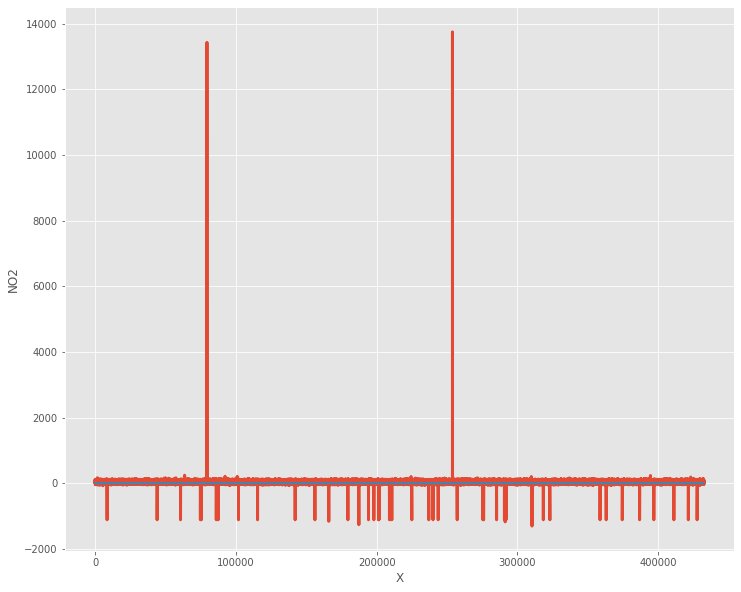

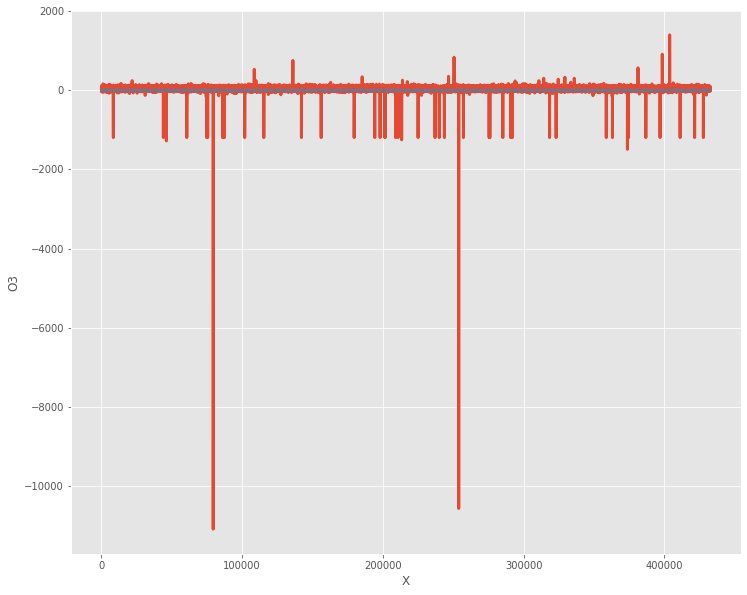

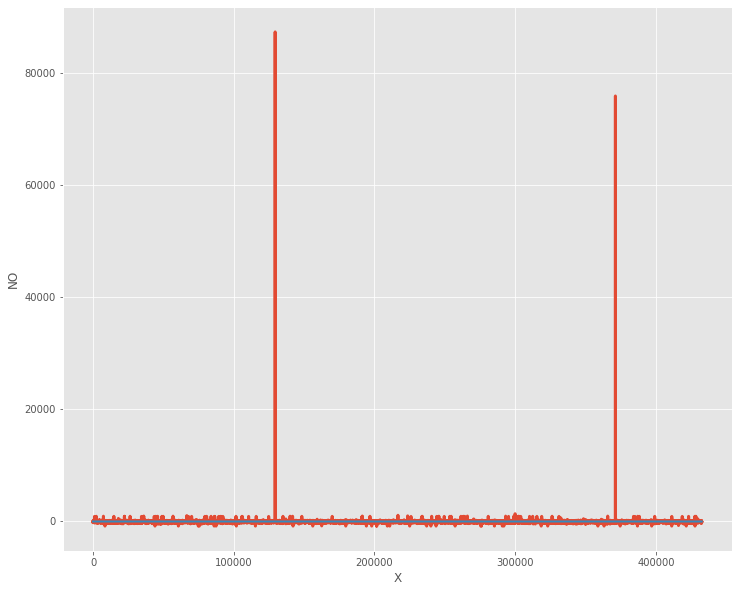

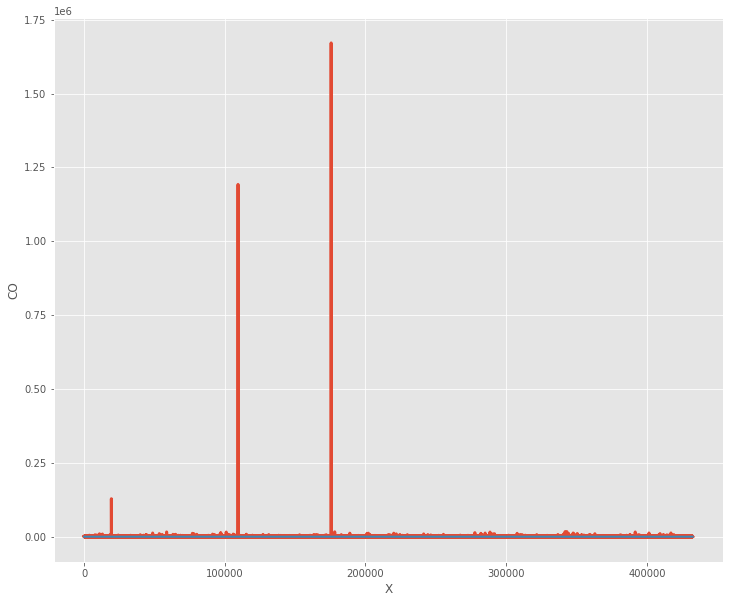

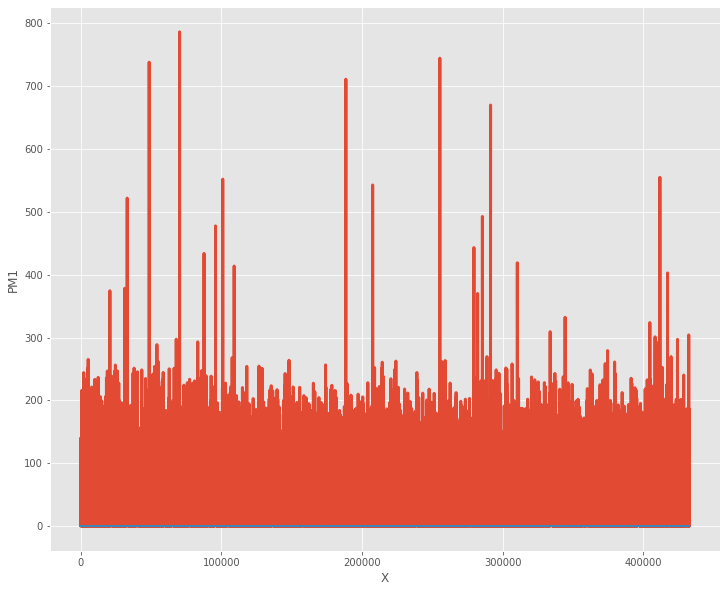

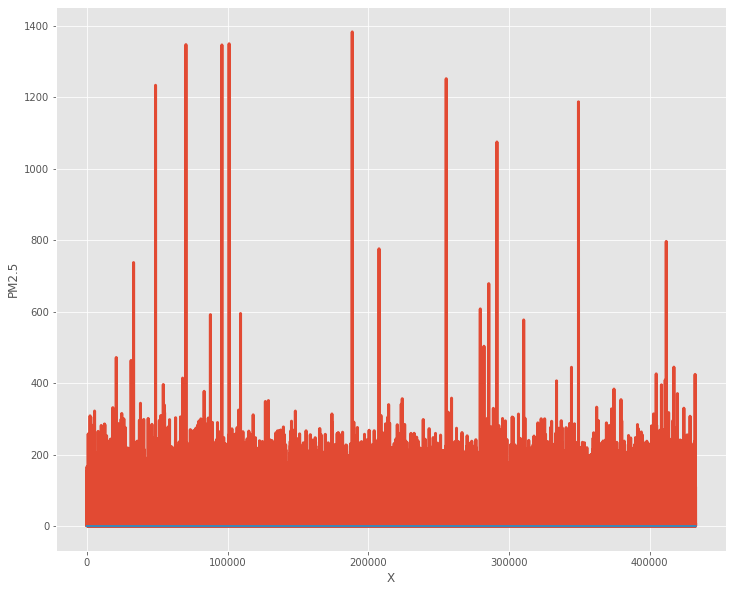

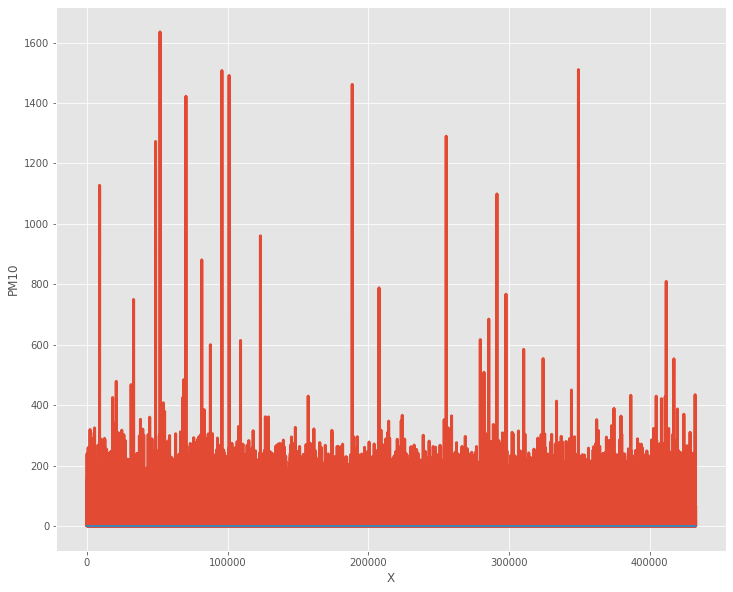

In [13]:
# printing y_test and y_test_predict
print("Y_Test:",y_test)
print("Y_Test_Predict:",y_test_pred2)

from matplotlib import style

style.use('ggplot')
for i in range(0,7):
  plt.figure(figsize=[12,10])
  plt.plot(y_test[:,i],linewidth=3, markersize=12)
  plt.plot(y_test_pred2[:,i],linewidth=2, markersize=12)
  plt.xlabel('X')
  plt.ylabel(train_sizes[i])
  plt.show()